In [1]:
import datetime as dt
from pathlib import Path
import os

import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

UserId  ItemId  Rating       Time
31            1    3186       4  978300019
22            1    1270       5  978300055
27            1    1721       4  978300055
37            1    1022       5  978300055
24            1    2340       3  978300103
...         ...     ...     ...        ...
1000019    6040    2917       4  997454429
999988     6040    1921       4  997454464
1000172    6040    1784       3  997454464
1000167    6040     161       3  997454486
1000042    6040    1221       4  998315055

[1000209 rows x 4 columns]

In [3]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [4]:
user_length = data.groupby('UserId').size()
user_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [5]:
long_user = user_length[user_length==200].index[0]
data[data['UserId']==long_user]

UserId  ItemId  Rating       Time
406366    2438     908       3  974222921
406379    2438    2294       3  974222921
406412    2438    3812       5  974222921
406418    2438    3835       2  974222921
406427    2438    1186       4  974222921
...        ...     ...     ...        ...
406356    2438    3948       4  979792076
406461    2438    2502       4  981262001
406372    2438    1466       4  981322989
406413    2438    1131       5  987127691
406414    2438    1132       4  987127748

[200 rows x 4 columns]

In [6]:
user_count = user_length.groupby(user_length).size()
user_percent_cumsum = user_count.cumsum() / user_count.sum()
user_percent_cumsum_999 = user_percent_cumsum[user_percent_cumsum < 0.999]

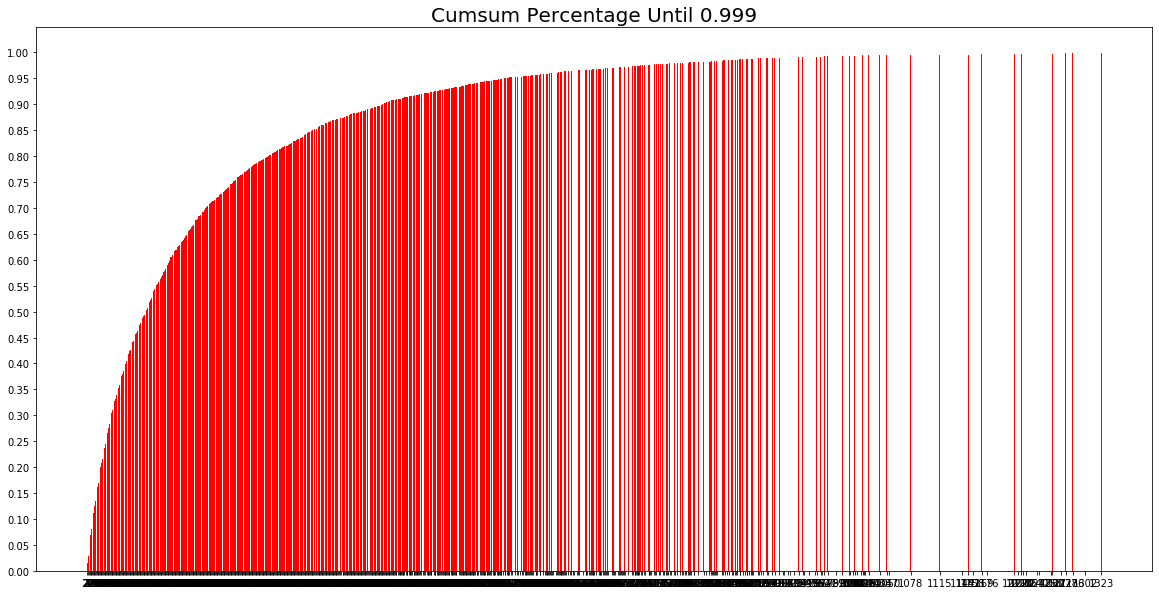

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.bar(x=user_percent_cumsum_999.index,
        height=user_percent_cumsum_999, color='red')
plt.xticks(user_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title('Cumsum Percentage Until 0.999', size=20)
plt.show()

In [8]:
oldest, latest = data['Time'].min(), data['Time'].max()
print(oldest) 
print(latest)

956703932
1046454590


In [9]:
type(latest)

int

# 노드에는 6개월치 데이터 중 1개월치만 보길 원합니다. 하지만 저는 3년치 데이터 전체를 이용하여 학습을 시킬 계획입니다.

In [10]:
#month_ago = latest - 30   # 최종 날짜로부터 30일 이전 날짜를 구한다.  
#data = data[data['Time'] > month_ago]   # 방금 구한 날짜 이후의 데이터만 모은다. 
#data

# 2. Data Cleansing

In [11]:
# Rating  이 3 이상인 영화만 

data = data[data['Rating']>=3]
data

UserId  ItemId  Rating       Time
31            1    3186       4  978300019
22            1    1270       5  978300055
27            1    1721       4  978300055
37            1    1022       5  978300055
24            1    2340       3  978300103
...         ...     ...     ...        ...
1000019    6040    2917       4  997454429
999988     6040    1921       4  997454464
1000172    6040    1784       3  997454464
1000167    6040     161       3  997454486
1000042    6040    1221       4  998315055

[836478 rows x 4 columns]

def cleanse_recursive(data: pd.DataFrame, shortest, least_score) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_user(data, shortest)
        data = cleanse_unpopular_movie(data, least_score)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_user(data: pd.DataFrame, shortest):
    user_len = data.groupby('UserId').size()
    user_use = user_len[user_len >= shortest].index
    data = data[data['UserId'].isin(user_use)]
    return data


def cleanse_unpopular_movie(data: pd.DataFrame, least_score):
    item_popular = data.groupby('Rating').size()
    item_use = item_popular[item_popular > least_score].index
    data = data[data['ItemId'].isin(item_use)]
    return data

data = cleanse_recursive(data, shortest = 2, least_score = 1)
data

In [12]:
test_path = data_path / 'ratings.dat'
test= load_data(test_path)
test['Time'].min(), test['Time'].max()

(956703932, 1046454590)

# date 으로 나누지않고 그냥 일정 비율로 split 하였습니다

def split_by_date(data: pd.DataFrame, n_days: int):
    final_time = data['Time'].max()
    user_last_time = data.groupby('UserId')['Time'].max()
    user_in_train = user_last_time[user_last_time < final_time - n_days].index
    user_in_test = user_last_time[user_last_time >= final_time - n_days].index

    before_date = data[data['UserId'].isin(user_in_train)]
    after_date = data[data['UserId'].isin(user_in_test)]
    after_date = after_date[after_date['ItemId'].isin(before_date['ItemId'])]
    return before_date, after_date

tr, test = split_by_date(data, n_days=1)
tr, val = split_by_date(tr, n_days=1)

In [13]:
tr, val, test = np.split(data.sample(frac=1), [int(.6*len(data)), int(.8*len(data))])

In [14]:
# data에 대한 정보를 살펴봅니다.
def stats_info(data: pd.DataFrame, status: str):
    print(f'* {status} Set Stats Info\n'
          f'\t Events: {len(data)}\n'
          f'\t UserID: {data["UserId"].nunique()}\n'
          f'\t Items: {data["ItemId"].nunique()}\n'
          f'\t First Time : {data["Time"].min()}\n'
          f'\t Last Time : {data["Time"].max()}\n')

In [15]:
stats_info(tr, 'train')
stats_info(val, 'valid')
stats_info(test, 'test')

* train Set Stats Info
	 Events: 501886
	 UserID: 6039
	 Items: 3563
	 First Time : 956703932
	 Last Time : 1046454548

* valid Set Stats Info
	 Events: 167296
	 UserID: 6024
	 Items: 3346
	 First Time : 956704056
	 Last Time : 1046454260

* test Set Stats Info
	 Events: 167296
	 UserID: 6020
	 Items: 3360
	 First Time : 956703977
	 Last Time : 1046454590



In [16]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(tr['ItemId'].unique())}

def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

tr = indexing(tr, id2idx)
val = indexing(val, id2idx)
test = indexing(test, id2idx)

In [17]:
class SessionDataset:

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['UserId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['UserId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('UserId').size().cumsum()
        return offsets

In [18]:
tr_dataset = SessionDataset(tr)
tr_dataset.df.head(10)

UserId  ItemId  Rating       Time  item_idx
52483      346     945       5  976333862         0
542254    3336    1513       3  967855899         1
901559    5450    2644       4  959960191         2
921266    5566    1287       4  959352245         3
199538    1224     105       3  975167625         4
685202    4095    2696       5  965424397         5
160082    1019    1175       4  975351440         6
24292      173     898       4  977164143         7
894710    5404    2889       3  960345173         8
314297    1876    2541       4  974693402         9

In [19]:
tr_dataset.click_offsets

array([     0,     32,    108, ..., 501649, 501722, 501886], dtype=int32)

In [20]:
tr_dataset.session_idx

array([   0,    1,    2, ..., 6036, 6037, 6038])

In [21]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=50):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [22]:
tr_data_loader = SessionDataLoader(tr_dataset, batch_size=4)
tr_dataset.df.head(15)

UserId  ItemId  Rating       Time  item_idx
52483      346     945       5  976333862         0
542254    3336    1513       3  967855899         1
901559    5450    2644       4  959960191         2
921266    5566    1287       4  959352245         3
199538    1224     105       3  975167625         4
685202    4095    2696       5  965424397         5
160082    1019    1175       4  975351440         6
24292      173     898       4  977164143         7
894710    5404    2889       3  960345173         8
314297    1876    2541       4  974693402         9
445910    2750     235       5  973199612        10
707860    4241    2013       3  983483146        11
384100    2244    2890       5  974595421        12
335035    1976      62       4  974689525        13
895883    5414    1242       4  960237678        14

In [23]:
iter_ex = iter(tr_data_loader)

In [24]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [  0  31 103 127]
Label Item Idx are :       [  1  32 104 128]
Previous Masked Input Idx are []


In [25]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

# 3. 모델 만들기

In [26]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [27]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [28]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['UserId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(tr, val, test, batch_size=2048, hsz=50, drop_rate=0.1, lr=0.001, epochs=10, k=20)

In [29]:
model = create_model(args)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(2048, 1, 3563)]         0         
_________________________________________________________________
GRU (GRU)                    [(2048, 50), (2048, 50)]  542250    
_________________________________________________________________
dropout (Dropout)            (2048, 50)                0         
_________________________________________________________________
dense (Dense)                (2048, 3563)              181713    
Total params: 723,963
Trainable params: 723,963
Non-trainable params: 0
_________________________________________________________________


In [30]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['UserId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['UserId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [31]:
#모델 훈련 시작
train_model(model, args)

Train:   0%|          | 0/242 [00:00<?, ?it/s, accuracy=0.00244, train_loss=7.44]

	 - Recall@20 epoch 1: 0.057524
	 - MRR@20    epoch 1: 0.011108



Train:   0%|          | 0/242 [00:00<?, ?it/s, accuracy=0.00244, train_loss=7.43]

	 - Recall@20 epoch 2: 0.058105
	 - MRR@20    epoch 2: 0.011277



Train:   0%|          | 0/242 [00:00<?, ?it/s, accuracy=0.00391, train_loss=7.43]

	 - Recall@20 epoch 3: 0.057430
	 - MRR@20    epoch 3: 0.011264



Train:   0%|          | 0/242 [00:00<?, ?it/s, accuracy=0.00391, train_loss=7.42]

	 - Recall@20 epoch 4: 0.057461
	 - MRR@20    epoch 4: 0.011251



Train:   0%|          | 0/242 [00:00<?, ?it/s, accuracy=0.00391, train_loss=7.42]

	 - Recall@20 epoch 5: 0.057493
	 - MRR@20    epoch 5: 0.011478



Train:   0%|          | 0/242 [00:00<?, ?it/s, accuracy=0.00537, train_loss=7.42]

	 - Recall@20 epoch 6: 0.057399
	 - MRR@20    epoch 6: 0.011418



Train:   0%|          | 0/242 [00:00<?, ?it/s, accuracy=0.00537, train_loss=7.42]

	 - Recall@20 epoch 7: 0.057295
	 - MRR@20    epoch 7: 0.011511



Train:   0%|          | 0/242 [00:00<?, ?it/s, accuracy=0.00488, train_loss=7.41]

	 - Recall@20 epoch 8: 0.057409
	 - MRR@20    epoch 8: 0.011556



Train:   0%|          | 0/242 [00:00<?, ?it/s, accuracy=0.00342, train_loss=7.41]

	 - Recall@20 epoch 9: 0.057233
	 - MRR@20    epoch 9: 0.011531



Evaluation:  60%|██████    | 47/78 [03:50<02:32,  4.91s/it]

	 - Recall@20 epoch 10: 0.057347
	 - MRR@20    epoch 10: 0.011449



In [32]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

test_model(model, args, test)

Evaluation:  60%|██████    | 47/78 [03:50<02:32,  4.91s/it]

	 - Recall@20: 0.057908
	 - MRR@20: 0.011316

